In [1]:
%matplotlib inline
import scipy.optimize as sco
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
with open('returns.txt','r',encoding = 'utf-16') as f:
    string = f.read()
string.encode('utf-8').decode('utf-8')

with open('mb64.txt','r',encoding = 'utf-16') as fmb64:
    string1 = fmb64.read()
string1.encode('utf-8').decode('utf-8')
string1 = string1.replace('\t',',')
string = string.replace('\t',',')

with open('mb64.csv','w',encoding = 'utf-8') as fmb641:
    fmb641.write(string1)

with open('returns1.csv','w',encoding = 'utf-8') as f1:
    f1.write(string)

In [3]:
# Create a table "excess_return" by subtacting mb64 from returnstable
def get_excess_return():
    mb64 = pd.read_csv("mb64.csv")
    mb64.columns = ['dates','mb64']
    del mb64['dates']
    mb64 = mb64.apply(pd.to_numeric, errors = 'coerce')
    mb64 = mb64/12

    returnstable = pd.read_csv("returns1.csv") 
    returnstable = returnstable.join(mb64)

    returnstable = returnstable.drop(returnstable.index[0])
    returnstable.rename(columns=lambda x: x[0:4], inplace=True)
    returnstable.set_index('Unna', inplace=True)

    returnstable.rename(index=lambda x:x.split('/')[0]+'-'+x.split('/')[1], inplace=True)
    returnstable = returnstable.apply(pd.to_numeric, errors = 'coerce')

    excess_return = returnstable.subtract(returnstable['mb64'], axis=0)/100
    del excess_return['mb64']
    del returnstable
    return excess_return

In [4]:
#input format: list[,,,], string,string
def Insert_request_data():
    comp_str = input("Input required companies:")
    company = comp_str.split(',')
    from_date = input("Input From date:")
    to_date = input("Input To date:")
    return company, from_date, to_date

#companies,from_date,to_date = Insert_request_data()


#should create a function of parsing input companies and dates into list
def find_company_returns(companies,from_date,to_date):
    excess_return = get_excess_return()
    df = excess_return[companies].loc[from_date:to_date]
    del excess_return
    return df

companies = ['1201','1460','2010','2330','2489','2608','2889','3514','5522','9904']
from_date='2010-1'
to_date='2014-12'
#assign the numbers of companies to the variable num_of_coms
num_of_coms = len(companies)
company_returns = find_company_returns(companies,from_date,to_date)

In [5]:
#build the Markowitz table

#input forecasted excess return
"""raw_FER = input("Input forecasted excess return:")
FER = list(raw_FER.split(',')[:])
FER = list(map(float, FER))
print(FER)"""

#preset forecasted excess return (development use)
FER = [0.03,0.08,0.09,0.1,0.15,0.06,0.12,0.05,0.09,0.06]
FER_Ser = pd.Series(FER)

def create_random_weights():
    weights = np.random.random(num_of_coms)
    weights /= np.sum(weights)
    weights = pd.Series(weights,index=companies)
    return weights

Markowitz = company_returns.cov()*12


#Create companies_SD
companies_SD = np.zeros((len(companies)))
for i in range(len(companies)):
    companies_SD[i] = np.sqrt(Markowitz.iloc[i][i])
#print(companies_SD)

#Store FER_Ser in comapnies_MEAN
companies_MEAN = FER_Ser


def assign_random_weight(weights):
    #x = Markowitz.mul(weights, axis=0).sum()
    #x = x.mul(weights, axis=0)
    SD = np.sqrt(np.dot(weights.T,np.dot(Markowitz,weights)))
    Mean = weights.mul(FER,axis=0).sum()
    #SD = math.sqrt(x.sum())
    Slope = Mean/SD
    return Mean,SD,Slope

#Mean,SD,Slope = assign_random_weight(weights)
#print(Mean,SD,Slope)


In [6]:
#create points of portfolios
all_Mean_points=[]
all_SD_points=[]
all_Slope_points=[]
for p in range(4000):
    weights = create_random_weights()
    Mean,SD,Slope = assign_random_weight(weights)
    all_Mean_points.append(Mean)
    all_SD_points.append(SD)
    all_Slope_points.append(Slope)

all_Mean_points=pd.Series(all_Mean_points)
all_SD_points=pd.Series(all_SD_points)
all_Slope_points=pd.Series(all_Slope_points)


#data = pd.concat([all_Mean_points,all_SD_points],axis=1)
#print(data)
"""plt.figure(figsize=(8,4))
plt.scatter(all_SD_points,all_Mean_points, c = all_Slope_points, marker="o")
plt.grid(True)
plt.xlabel("SD")
plt.ylabel("Mean")
plt.ylim([0, 0.2])
plt.xlim([0, 0.3])
plt.colorbar(label="Sharpe ratio")"""


'plt.figure(figsize=(8,4))\nplt.scatter(all_SD_points,all_Mean_points, c = all_Slope_points, marker="o")\nplt.grid(True)\nplt.xlabel("SD")\nplt.ylabel("Mean")\nplt.ylim([0, 0.2])\nplt.xlim([0, 0.3])\nplt.colorbar(label="Sharpe ratio")'

In [7]:
def statistics(weight):
    weight = np.array(weight)
    Mean = np.sum(weight*FER)
    x = Markowitz.mul(weight, axis=0).sum()
    x = x.mul(weight, axis=0)
    SD = math.sqrt(x.sum())
    #print(SD)
    #SD = np.sqrt(np.dot(weight.T, np.dot(Markowitz,weights)))
    Sharpe_ratio = Mean/SD
    return np.array([Mean,SD,Sharpe_ratio])

#Find the optimal point with max Sharpe Ratio
def min_sharpe(weight):
    return -statistics(weight)[2]

#Store datapoints stats
def store_data(data):
    arr = np.array(list(statistics(data['x']))+list(data['x']))
    return arr

#test_weights = np.array([0.0000,0.0000,0.1183,0.4262,0.1710,0.1246,0.1526,0.0000,0.0072,0.0000])
#print(min_sharpe(test_weights))
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

#Find optimal portfolio for short/non-short
#control bnds, x=True for short, x=False for non-short
bnds = None
def set_short(x):
    global bnds
    if (x==True):
        bnds = None
    else:
        bnds =tuple((0,1)for x in range (num_of_coms))


print(set_short(False))
print(bnds)


def get_opts():
    opts = sco.minimize(min_sharpe,num_of_coms*[1./num_of_coms,],method='SLSQP', bounds=bnds, constraints=cons)
    opts = store_data(opts)
    return(opts)

opts = get_opts()
print(opts)

None
((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
[  1.05363332e-01   1.20520835e-01   8.74233338e-01   0.00000000e+00
   4.53672552e-17   1.17864844e-01   4.26356037e-01   1.71015852e-01
   1.24767294e-01   1.52727975e-01   3.07122353e-17   7.26799876e-03
   0.00000000e+00]


In [8]:
#Find the point with min variance

def min_variance(weight):
    return statistics(weight)[1]


def get_optv():
    optv = sco.minimize(min_variance,num_of_coms*[1./num_of_coms,],method='SLSQP', bounds=bnds, constraints=cons)
    optv = store_data(optv)
    return(optv)

optv = get_optv()
print(optv)

[  9.16817096e-02   1.13170729e-01   8.10118571e-01   5.07425150e-18
   1.37304195e-02   1.94815227e-01   4.23449661e-01   3.48107193e-02
   1.63517019e-01   8.11808509e-02   1.98104546e-18   2.06947399e-02
   6.78013637e-02]


In [9]:
#Find points on Efficient frontier
#Set numbers of points between optv and opts
num = 10

#Set short
#set_short(True)

def get_data_points(short_flag):
    global target_returns, data_above_opts
    set_short(short_flag)
    #get optv and opts
    opts = get_opts()
    optv = get_optv()

    #Set target data by returns
    target_returns = np.linspace(optv[0],opts[0],num)
    data_above_opts = np.linspace(opts[0],FER_Ser.max(),num*2)
    #return target_returns, data_above_opts

get_data_points(False)
print(target_returns)

[ 0.09168171  0.09320189  0.09472207  0.09624225  0.09776243  0.09928261
  0.10080279  0.10232297  0.10384315  0.10536333]


In [10]:
#Functionalize the optimizing process
def optimize_targets(returns,short_flag):
    get_data_points(short_flag)
    target_data = np.zeros(shape=(0,3+num_of_coms))
    for tar in returns:
        cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq', 'fun':lambda x: np.sum(x)-1})
        res = sco.minimize(min_variance,num_of_coms*[1./num_of_coms,],method='SLSQP', bounds=bnds, constraints=cons)
        res = store_data(res)
        res = res.reshape(1,len(res))
        target_data = np.concatenate((target_data,res))

    return(target_data)

#Combine data for all required points
def get_combined_data(short_flag):
    combined_data = np.append(np.delete(optimize_targets(target_returns,short_flag)\
    ,num-1,axis=0),optimize_targets(data_above_opts,short_flag),axis = 0)

    return combined_data


In [11]:
#print(target_data)

#Create dataframe 'all_data' containing Mean, SD, Slope and Weights of the points on EF
def create_data_table(target_data):
    ind=['Returns','Risks','Sharpe']
    all_data = pd.DataFrame(target_data).T
    all_data.index = ind + companies
    all_data = all_data.rename(columns = {0:'Min Var',num-1:'Optimum'})
    return all_data

all_data = create_data_table(get_combined_data(True))


#target_data = np.concatenate(target_data_returns, target_variance,target_sharpe)

In [12]:
#Functionalize the whole process and create two dataframes for short and non-short
def create_table_on_short(short_flag):
    set_short(short_flag)
    opts = get_opts()
    optv = get_optv()
    target_returns = np.linspace(optv[0],opts[0],num)
    data_above_opts = np.linspace(opts[0],FER_Ser.max(),num*2)
    all_data = create_data_table(get_combined_data(short_flag))

    return all_data

short = create_table_on_short(True)
non_short = create_table_on_short(False)


(0, 0.3)

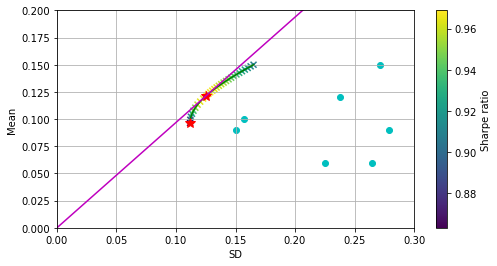

In [15]:
#Draw CAL
#Get the sharpe ratio of the optimum point as the slope of CAL
def draw_CAL(all_data,color):
    CAL_slope = all_data.loc['Sharpe']['Optimum']
    CAL = np.array([0,0.25])*CAL_slope
    plt.plot([0,0.25],CAL,color)
    return

#plot the Efficient frontier
def plot_EF(all_data,color):
    plt.scatter(all_data.loc['Risks'],all_data.loc['Returns'], c = all_data.loc['Sharpe'], marker="x")
    plt.plot(all_data.loc['Risks'],all_data.loc['Returns'],'-g')
    plt.plot(all_data.loc['Risks']['Min Var'],all_data.loc['Returns']['Min Var'],'r*',markersize = 10.0)
    plt.plot(all_data.loc['Risks']['Optimum'],all_data.loc['Returns']['Optimum'],'r*',markersize = 10.0)
    plt.colorbar(label="Sharpe ratio")
    draw_CAL(all_data,color)
    return

plt.figure(figsize=(8,4))
#plt.scatter(all_SD_points,all_Mean_points, c = all_Slope_points, marker="o")
plot_EF(short,'-m')
#plot_EF(non_short,'-b')
plt.scatter(companies_SD,companies_MEAN, c='c', marker="o")
plt.grid(True)
plt.xlabel("SD")
plt.ylabel("Mean")
plt.ylim([0, 0.2])
plt.xlim([0, 0.3])



In [ ]:
#apply indifference curve
#input risk aversion coefficient
A = input("Insert your risk aversion coefficient:")

